In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.tokenize import word_tokenize # nltk's gold standard word tokenizer
from nltk.corpus import stopwords #used for removing tokens in english stopword list
from nltk.stem import SnowballStemmer # stemming for text normalization

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier

# import pickle
import dill as pickle
import matplotlib.pyplot as plt

In [45]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asudhakar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/asudhakar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Loading data in:

In [46]:
sms_df = pd.read_csv('../data/spam.csv', encoding='latin')
sms_df = sms_df[['v1', 'v2']].rename(columns={'v1': 'target', 'v2': 'text'})
sms_df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Input Preprocessing

We are going to be writing a simple text input preprocessing pipeline.

In [47]:
def lowering_func(x):
    return x.str.lower()

def tokenizer(x, tokenizer):
    return x.apply(tokenizer)

def text_normalizer(x, stopword_list):

    # use Snowballstemmer
    stemmer = SnowballStemmer('english')

    # apply stemmer and filter out stop words and keep only alphabetic characters
    # this removes numbers and punctuation
    # removes words that are extremely common in the english language and are not semantically
    sw_removed = x.apply(lambda txt: [stemmer.stem(elem) for elem in txt if ( (elem not in stopword_list) & elem.isalpha() )  ] )

    return sw_removed

def rejoiner(x):
    rejoined = x.str.join(" ")
    return rejoined

lower_text = FunctionTransformer(lowering_func)
apply_tokenizer = FunctionTransformer(tokenizer, kw_args={'tokenizer': word_tokenize} )
normalizer = FunctionTransformer(text_normalizer, kw_args={'stopword_list': stopwords.words('english') } )
stringjoin =  FunctionTransformer(rejoiner)
countvec = CountVectorizer(min_df = 0.01, max_df = 0.95)

### Construct preprocessing pipeline
- Pipeline composes sequence of transformations and vectorization into a single object
- A lot of advantages: 
    - packaging preprocessing in single entity
    - less code
    - use Scikit-learn's functionality: rapidly try out different options of FunctionTransformers in Pipeline and parameters of vectorizer during model tuning.
    - swap in and out components


**Modularity and Extensibility**

In [48]:
nlp_preprocess_pipe = Pipeline([('lower', lower_text), ('tokenizer', apply_tokenizer), ('textnorm', normalizer), ('join', stringjoin), ('vec', countvec) ])

In [49]:
X = sms_df['text']
y = sms_df['target']

In [50]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3)

In [51]:
nlp_preprocess_pipe.fit_transform(X_train)

<3900x147 sparse matrix of type '<class 'numpy.int64'>'
	with 12111 stored elements in Compressed Sparse Row format>

Save your preprocessor separately from the model:
- use pickle to save representation of preprocessor (trained on your dataset)
- preprocessor can be reused to transform new data (under assumption it follows distribution of training data)


## Modeling

In the pipeline framework: 
- adding a final estimator step after preprocessing chain -- this will be our classifier
- data transformation + predictive modeling in one combined estimator

In [52]:
modeling_pipe = Pipeline([('preprocess', nlp_preprocess_pipe ), ('model', RandomForestClassifier())])

Fit entire pipeline on training data:

In [53]:
modeling_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('lower',
                                  FunctionTransformer(func=<function lowering_func at 0x2b44a49a0>)),
                                 ('tokenizer',
                                  FunctionTransformer(func=<function tokenizer at 0x2b44a4b80>,
                                                      kw_args={'tokenizer': <function word_tokenize at 0x177043240>})),
                                 ('textnorm',
                                  FunctionTransformer(func=<function text_normalizer at 0x2b44a4c20>,
                                                      kw_args={'stopword_list...
                                                                                 'ours',
                                                                                 'ourselves',
                                                                                 'you',
                                                                                 "you're",
                                                                                 "you've",
                                                                                 "you'll",
                                                                                 "you'd",
                                                                                 'your',
                                                                                 'yours',
                                                                                 'yourself',
                                                                                 'yourselves',
                                                                                 'he',
                                                                                 'him',
                                                                                 'his',
                                                                                 'himself',
                                                                                 'she',
                                                                                 "she's",
                                                                                 'her',
                                                                                 'hers',
                                                                                 'herself',
                                                                                 'it',
                                                                                 "it's",
                                                                                 'its',
                                                                                 'itself', ...]})),
                                 ('join',
                                  FunctionTransformer(func=<function rejoiner at 0x2b44a4cc0>)),
                                 ('vec',
                                  CountVectorizer(max_df=0.95, min_df=0.01))])),
                ('model', RandomForestClassifier())])

After model training, evaluate model on test data:
- get class predictions given test text inputs
- in practice, there is model tuning/validation (we won't cover this here)

In [54]:
y_pred = modeling_pipe.predict(X_test)

#### Model Evaluation
- Did our pipeline (data transformation + classifier) do a good job on the test set?

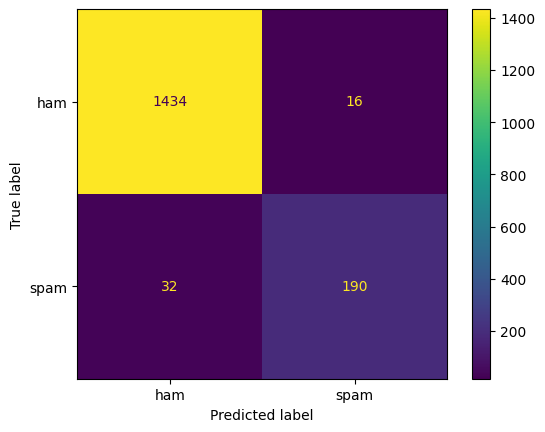

In [55]:
cfmat = confusion_matrix(y_test, y_pred)

ax = ConfusionMatrixDisplay(cfmat, display_labels = y.unique()).plot()

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.98      1450
        spam       0.92      0.86      0.89       222

    accuracy                           0.97      1672
   macro avg       0.95      0.92      0.94      1672
weighted avg       0.97      0.97      0.97      1672



This model is doing pretty well. 
- Save trained model for deployment.

In [57]:
pickle.dump(modeling_pipe, open('../saved_models/full_pipeline.pkl', 'wb'))

Next steps:
- Get out of the Jupyter notebook
- Create python module for importing necessary functions 